# Image generation

In Part 1 of this course, we focused mainly on models that were useful for classification. However, many applications require generating much higher dimensional results, such as images and sentences. Examples include:
* Text: neural translation, text to speech, image captioning
* Image: Segmentation, artistic filters, image sharpening and cleaning

In [1]:
%matplotlib inline
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
from keras import metrics

from vgg16_avg import VGG16_Avg

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Tell Tensorflow to use no more GPU RAM than necessary
limit_mem()

Data can be downloaded from [here](http://files.fast.ai/data/imagenet-sample-train.tar.gz). Update path below to where you download data to. Optionally use a 2nd path for fast (e.g. SSD) storage - set both to the same path if using AWS.

In [3]:
path = 'data/styleTransfer/'
dpath = '/data/jhoward/fast/imagenet/sample/'

## Neural style transfer

The first use case of an image to image architecture we're going to look at is neural style transfer, using the approach in [this paper](https://arxiv.org/abs/1508.06576). This is a fairly popular application of deep learning in which an image is recreated in the style of a work of art, such as Van Gogh's Starry Night. For more information about the use of neural networks in art, see this [Scientific American article](https://blogs.scientificamerican.com/sa-visual/neural-networks-for-artists/) or [Google's Magenta Project](https://magenta.tensorflow.org/welcome-to-magenta).

### Setup

Our first step is to list out the files we have, and then grab some image.

In [4]:
fn = f'{path}dommiAndJC.JPG'; fn

'data/styleTransfer/dommiAndJC.JPG'

In [39]:
img=Image.open(fn)

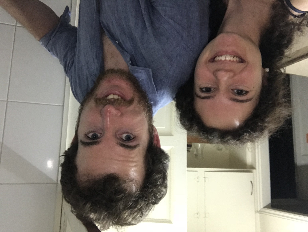

In [40]:
img = img.resize(np.divide(img.size,10).astype('int32')); img

In [41]:
img = np.flipud(img)

That's a nice looking image! Feel free to use any other image that you're interested in playing with.

We'll be using this image with VGG16. Therefore, we need to subtract the mean of each channel of the imagenet data and reverse the order of RGB->BGR since those are the preprocessing steps that the VGG authors did - so their model won't work unless we do the same thing.

We can do this in one step using *broadcasting*, which is a topic we'll be returning to many times during this course.

In [15]:
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]

When we generate images from this network, we'll need to undo the above preprocessing in order to view them.

In [16]:
deproc = lambda x,s: np.clip(x.reshape(s)[:, :, :, ::-1] + rn_mean, 0, 255)

In [43]:
img_arr = preproc(np.expand_dims(np.array(img), 0))
shp = img_arr.shape

#### Broadcasting examples

In [24]:
np.array([1,2,3]) - 2

array([-1,  0,  1])

In [25]:
np.array([2,3]).reshape(1,1,1,2)

array([[[[2, 3]]]])

In [26]:
np.array([2,3]).reshape(1,1,2,1)

array([[[[2],
         [3]]]])

In [27]:
a = np.random.randn(5,1,3,2)
b = np.random.randn(2)
(a-b).shape

(5, 1, 3, 2)

### Recreate input

The first step in style transfer is understanding how to recreate an image from noise based on "content loss", which is the amount of difference between activations in some layer. In earlier layes, content loss is very similar to per-pixel loss, but in later layers it is capturing the "meaning" of a part of an image, rather than the specific details.

To do this, we first take a CNN and pass an image through it. We then pass a "noise image" (i.e. random pixel values) through the same CNN. At some layer, we compare the outputs from it for both images. We then use a MSE to compare the activations of these two outputs. 

The interesting part is that now, instead of updating the parameters of the CNN, we update the pixels of the noisy image. In other words, our goal is to alter the noisy image so as to minimize the difference between the original image's output at some convolutional layer with the output of the noisy image at the same layer.

In order to construct this architecture, we're going to be working with keras.backend, which is an abstraction layer that allows us to target both theano and tensorflow with the same code.

The CNN we'll use is VGG16, but with a twist. Previously we've always used Vgg with max pooling, and this was useful for image classification. It's not as useful in this case however, because max pooling loses information about the original input area. Instead we will use average pooling, as this does not throw away as much information.

In [12]:
model = VGG16_Avg(include_top=False)

Here we're grabbing the activations from near the end of the convolutional model).

In [13]:
layer = model.get_layer('block5_conv1').output

And let's calculate the target activations for this layer:

In [14]:
layer_model = Model(model.input, layer)
targ = K.variable(layer_model.predict(img_arr))

In our implementation, we need to define an object that will allow us to separately access the loss function and gradients of a function, since that is what scikit-learn's optimizers require.

In [18]:
class Evaluator(object):
    def __init__(self, f, shp): self.f, self.shp = f, shp
        
    def loss(self, x):
        loss_, self.grad_values = self.f([x.reshape(self.shp)])
        return loss_.astype(np.float64)

    def grads(self, x): return self.grad_values.flatten().astype(np.float64)

We'll define our loss function to calculate the mean squared error between the two outputs at the specified convolutional layer.

In [16]:
loss = metrics.mse(layer, targ)
grads = K.gradients(loss, model.input)
fn = K.function([model.input], [loss]+grads)
evaluator = Evaluator(fn, shp)

Now we're going to optimize this loss function with a deterministic approach to optimization that uses a line search, which we can implement with sklearn's `fmin_l_bfgs_b` funtionc. 

In [57]:
import os
os.makedirs(f'{path}results', exist_ok=True)

In [56]:
def solve_image(eval_obj, niter, x):
    for i in range(niter):
        x, min_val, info = fmin_l_bfgs_b(eval_obj.loss, x.flatten(),
                                         fprime=eval_obj.grads, maxfun=20)
        x = np.clip(x, -127,127)
        print('Current loss value:', min_val)
        imsave(f'{path}results/res_at_iteration_{i}.png', deproc(x.copy(), shp)[0])
    return x

Next we need to generate a random image.

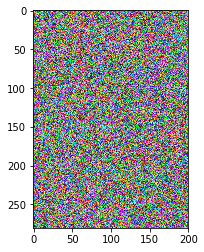

In [19]:
rand_img = lambda shape: np.random.uniform(0, 1, shape)
x = rand_img(shp)
plt.imshow(x[0]);

Now we'll run through this optimization approach ten times and train the noise image's pixels as desired.

In [20]:
iterations=10

In [46]:
x = solve_image(evaluator, iterations, x)

Current loss value: 10.756718635559082


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  import sys


Current loss value: 10.746503829956055
Current loss value: 10.706018447875977
Current loss value: 10.69620418548584
Current loss value: 10.655916213989258
Current loss value: 10.646183967590332
Current loss value: 10.605982780456543
Current loss value: 10.568052291870117
Current loss value: 10.558195114135742
Current loss value: 10.519086837768555


Our result by comparing output at conv 1 of last block (5) is fairly amorphous, but still easily recognizable as a bird. Notice that the things it has reconstructed particularly well are those things that we expect Vgg16 to be good at recognizing, such as an eye or a beak.

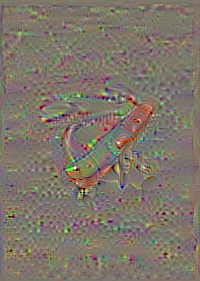

In [47]:
Image.open(path + 'results/res_at_iteration_9.png')

If instead we optimized by calculating loss from the output of conv 1 of 4th block, our trained image looks much more like the original. This makes sense because with less transformations to go through, comparing at an earlier layer means that we have a smaller receptive field and the features are more based on geometric details rather than broad features.

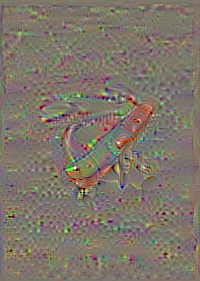

In [48]:
Image.open(path + 'results/res_at_iteration_9.png')

In [49]:
from IPython.display import HTML
from matplotlib import animation, rc

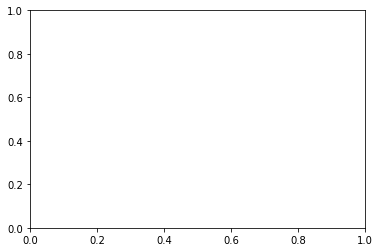

In [75]:
fig, ax = plt.subplots()
def animate(i): ax.imshow(Image.open(f'{path}results/res_at_iteration_{i*10}.png'))

The optimizer first focuses on the important details of the bird, before trying to match the background.

In [76]:
anim = animation.FuncAnimation(fig, animate, frames=100, interval=200)
HTML(anim.to_html5_video())

### Recreate style

Now that we've learned how to recreate an input image, we'll move onto attempting to recreate *style*. By "style", we mean the color palette and texture of an image. Unlike recreating based on content, with style we are not concerned about the actual structure of what we're creating, all we care about is that it captures this concept of "style".

Here are some examples of images we can extract style from.

In [19]:
def plot_arr(arr): plt.imshow(deproc(arr,arr.shape)[0].astype('uint8'))

In [20]:
style = Image.open(f'{path}starry_night.jpg')

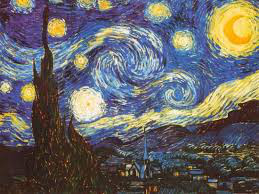

In [21]:
style

In [ ]:
style = style.resize(np.divide(style.size,6/4).astype('int32')); style

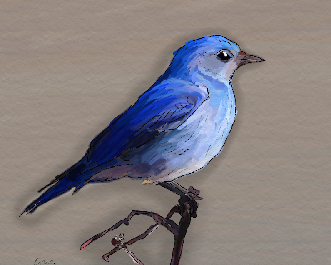

In [212]:
style = Image.open('data/bird.jpg')
style = style.resize(np.divide(style.size,2.4).astype('int32')); style

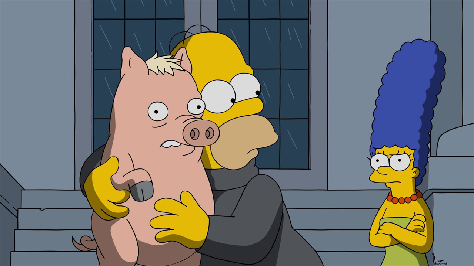

In [349]:
style = Image.open('data/simpsons.jpg')
style = style.resize(np.divide(style.size,2.7).astype('int32')); style

We're going to repeat the same approach as before, but with some differences.

In [65]:
style_arr.shape

(1, 194, 259, 3)

In [66]:
style_arr = preproc(np.expand_dims(style,0)[:,:,:,:3])
shp = style_arr.shape

In [67]:
model = VGG16_Avg(include_top=False, input_shape=shp[1:])
outputs = {l.name: l.output for l in model.layers}

One thing to notice is that we're actually going to be calculating the loss function multiple layers, rather than just one. (Note however that there's no reason you couldn't try using multiple layers in your content loss function, if you wanted to try that).

In [59]:
layers = [outputs['block{}_conv1'.format(o)] for o in range(1,3)]

In [60]:
layers_model = Model(model.input, layers)
targs = [K.variable(o) for o in layers_model.predict(style_arr)]

The key difference is our choice of loss function. Whereas before we were calculating mse of the raw convolutional outputs, here we transform them into the "gramian matrix" of their channels (that is, the product of a matrix and its transpose) before taking their mse. It's unclear why this helps us achieve our goal, but it works. One thought is that the gramian  shows how our features at that convolutional layer correlate, and completely removes all location information. So matching the gram matrix of channels can only match some type of texture information, not location information.

In [49]:
def gram_matrix(x):
    # We want each row to be a channel, and the columns to be flattened x,y locations
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    # The dot product of this with its transpose shows the correlation 
    # between each pair of channels
    return K.dot(features, K.transpose(features)) / x.get_shape().num_elements()

In [50]:
def style_loss(x, targ): return metrics.mse(gram_matrix(x), gram_matrix(targ))

In [63]:
loss = sum(style_loss(l1[0], l2[0]) for l1,l2 in zip(layers, targs))
grads = K.gradients(loss, model.input)
style_fn = K.function([model.input], [loss]+grads)
evaluator = Evaluator(style_fn, shp)

We then solve as we did before.

In [53]:
rand_img = lambda shape: np.random.uniform(0, 1, shape)/1

In [66]:
rand_img = lambda shape: np.random.uniform(0, 1, shape)/1
x = rand_img(shp)
x = scipy.ndimage.filters.gaussian_filter(x, [0,2,2,0])

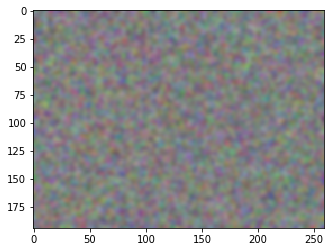

In [67]:
plt.imshow(x[0]);

In [71]:
iterations=1000
x = rand_img(shp)

In [72]:
x = solve_image(evaluator, iterations, x)

Current loss value: 15468.3896484375


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  import sys


Current loss value: 14354.31640625
Current loss value: 10840.9912109375
Current loss value: 10157.4892578125
Current loss value: 9547.986328125
Current loss value: 9008.3525390625
Current loss value: 8523.69140625
Current loss value: 8088.82958984375
Current loss value: 6760.80126953125
Current loss value: 6470.50048828125
Current loss value: 6189.166015625
Current loss value: 5228.56982421875
Current loss value: 5157.02783203125
Current loss value: 5093.669921875
Current loss value: 4876.49853515625
Current loss value: 4667.45703125
Current loss value: 4472.49853515625
Current loss value: 4417.88525390625
Current loss value: 4222.3134765625
Current loss value: 4038.049560546875
Current loss value: 3868.71630859375
Current loss value: 3818.888671875
Current loss value: 3648.635986328125
Current loss value: 3602.83837890625
Current loss value: 3432.3095703125
Current loss value: 3278.31005859375
Current loss value: 3235.267333984375
Current loss value: 3078.102294921875
Current loss val

Current loss value: 253.84890747070312
Current loss value: 253.2461700439453
Current loss value: 252.64137268066406
Current loss value: 252.04808044433594
Current loss value: 251.45266723632812
Current loss value: 250.86505126953125
Current loss value: 250.27981567382812
Current loss value: 249.70523071289062
Current loss value: 249.1221160888672
Current loss value: 248.5490264892578
Current loss value: 247.9761962890625
Current loss value: 247.41012573242188
Current loss value: 246.84185791015625
Current loss value: 246.27822875976562
Current loss value: 245.71951293945312
Current loss value: 245.56057739257812
Current loss value: 244.96034240722656
Current loss value: 244.3670654296875
Current loss value: 243.78976440429688
Current loss value: 243.22071838378906
Current loss value: 242.66244506835938
Current loss value: 242.12208557128906
Current loss value: 241.96533203125
Current loss value: 241.3770294189453
Current loss value: 240.80032348632812
Current loss value: 240.2365264892

Current loss value: 165.5353240966797
Current loss value: 165.3849639892578
Current loss value: 165.248046875
Current loss value: 165.1373748779297
Current loss value: 164.7281494140625
Current loss value: 164.62225341796875
Current loss value: 163.086181640625
Current loss value: 162.94593811035156
Current loss value: 162.81552124023438
Current loss value: 162.7083740234375
Current loss value: 162.29742431640625
Current loss value: 162.19500732421875
Current loss value: 160.5996856689453
Current loss value: 160.4835205078125
Current loss value: 160.36895751953125
Current loss value: 159.9977264404297
Current loss value: 159.88816833496094
Current loss value: 159.486572265625
Current loss value: 159.38490295410156
Current loss value: 158.9806365966797
Current loss value: 158.61831665039062
Current loss value: 158.50888061523438
Current loss value: 158.13246154785156
Current loss value: 158.02532958984375
Current loss value: 157.62510681152344
Current loss value: 157.5260467529297
Curre

Current loss value: 61.18266296386719
Current loss value: 60.960243225097656
Current loss value: 60.741573333740234
Current loss value: 60.69334411621094
Current loss value: 59.819175720214844
Current loss value: 59.78267288208008
Current loss value: 59.72459411621094
Current loss value: 59.507869720458984
Current loss value: 59.29446029663086
Current loss value: 59.24409103393555
Current loss value: 58.46794128417969
Current loss value: 58.361907958984375
Current loss value: 58.30106735229492
Current loss value: 58.08629608154297
Current loss value: 57.87409210205078
Current loss value: 57.82802200317383
Current loss value: 57.004127502441406
Current loss value: 56.96869659423828
Current loss value: 56.90903854370117
Current loss value: 56.70147705078125
Current loss value: 56.49364471435547
Current loss value: 56.28561782836914
Current loss value: 56.09522247314453
Current loss value: 56.046077728271484
Current loss value: 55.835750579833984
Current loss value: 55.788543701171875
Cur

Current loss value: 39.265419006347656
Current loss value: 39.255516052246094
Current loss value: 39.21464538574219
Current loss value: 39.05299758911133
Current loss value: 39.05231857299805
Current loss value: 39.04130172729492
Current loss value: 39.03138732910156
Current loss value: 38.99087142944336
Current loss value: 38.83171081542969
Current loss value: 38.83024978637695
Current loss value: 38.81891632080078
Current loss value: 38.80879592895508
Current loss value: 38.7681884765625
Current loss value: 38.609527587890625
Current loss value: 38.60832977294922
Current loss value: 38.59691619873047
Current loss value: 38.58681106567383
Current loss value: 38.54658508300781
Current loss value: 38.38882064819336
Current loss value: 38.38844299316406
Current loss value: 38.37732696533203
Current loss value: 38.36733627319336
Current loss value: 38.32727813720703
Current loss value: 38.17013168334961
Current loss value: 38.16932678222656
Current loss value: 38.158050537109375
Current l

Our results are stunning. By transforming the convolutional outputs to the gramian, we are somehow able to update the noise pixels to produce an image that captures the raw style of the original image, with absolutely no structure or meaning.

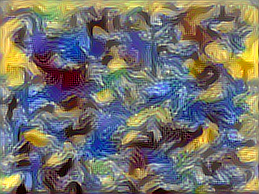

In [73]:
Image.open(path + 'results/res_at_iteration_1000.png')

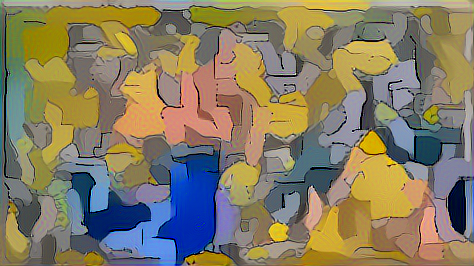

In [801]:
Image.open(path + 'res_at_iteration_9.png')

### Style transfer

We now know how to reconstruct an image, as well as how to construct an image that captures the style of an original image. The obvious idea may be to just combine these two approaches by weighting and adding the two loss functions.

In [60]:
shp= src.shape

In [61]:
shp

(1, 194, 259, 3)

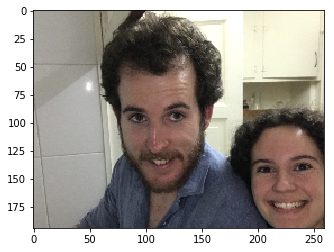

In [44]:
w,h = style.size
src = img_arr[:,:h,:w]
plot_arr(src)

Like before, we're going to grab a sequence of layer outputs to compute the style loss. However, we still only need one layer output to compute the content loss. How do we know which layer to grab? As we discussed earlier, the lower the layer, the more exact the content reconstruction will be. In merging content reconstruction with style, we might expect that a looser reconstruction of the content will allow more room for the style to have an effect (re: inspiration). Furthermore, a later layer ensures that the image "looks like" the same subject, even if it doesn't have the same details.

In [68]:
style_layers = [outputs['block{}_conv2'.format(o)] for o in range(1,6)]
content_name = 'block4_conv2'
content_layer = outputs[content_name]

In [69]:
style_model = Model(model.input, style_layers)
style_targs = [K.variable(o) for o in style_model.predict(style_arr)]

In [70]:
content_model = Model(model.input, content_layer)
content_targ = K.variable(content_model.predict(src))

Now to actually merge the two approaches is as simple as merging their respective loss functions. Note that as opposed to our previous to functions, this function is producing three separate types of outputs: one for the original image, one for the image whose style we're emulating, and one for the random image whose pixel's we are training. 

One way for us to tune how the reconstructions mix is by changing the factor on the content loss, which we have here as 1/10. If we increase that denominator, the style will have a larger effect on the image, and if it's too large the original content of the image will be obscured by unstructured style. Likewise, if it is too small than the image will not have enough style.

In [71]:
style_wgts = [0.05,0.2,0.2,0.25,0.3]

In [72]:
loss = sum(style_loss(l1[0], l2[0])*w
           for l1,l2,w in zip(style_layers, style_targs, style_wgts))
loss += metrics.mse(content_layer, content_targ)/10
grads = K.gradients(loss, model.input)
transfer_fn = K.function([model.input], [loss]+grads)

In [73]:
evaluator = Evaluator(transfer_fn, shp)

In [74]:
iterations=100
x = rand_img(shp)

In [82]:
x = solve_image(evaluator, 600, x)

Current loss value: 689.5084228515625


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  import sys


Current loss value: 688.712890625
Current loss value: 687.9628295898438
Current loss value: 687.763427734375
Current loss value: 686.9600830078125
Current loss value: 686.2000732421875
Current loss value: 686.0037841796875
Current loss value: 685.2077026367188
Current loss value: 684.4454345703125
Current loss value: 684.2515258789062
Current loss value: 683.4539794921875
Current loss value: 682.68701171875
Current loss value: 681.9625244140625
Current loss value: 681.762939453125
Current loss value: 680.9864501953125
Current loss value: 680.247802734375
Current loss value: 680.0506591796875
Current loss value: 679.2752685546875
Current loss value: 678.539306640625
Current loss value: 678.3461303710938
Current loss value: 677.5714111328125
Current loss value: 676.8477783203125
Current loss value: 676.6558837890625
Current loss value: 675.875244140625
Current loss value: 675.1502685546875
Current loss value: 674.9615478515625
Current loss value: 674.1868896484375
Current loss value: 673

Current loss value: 570.603759765625
Current loss value: 570.4344482421875
Current loss value: 570.2904052734375
Current loss value: 568.1409301757812
Current loss value: 568.0255126953125
Current loss value: 567.876953125
Current loss value: 567.3264770507812
Current loss value: 567.1920166015625
Current loss value: 565.076171875
Current loss value: 564.946044921875
Current loss value: 564.793701171875
Current loss value: 564.296142578125
Current loss value: 564.1558227539062
Current loss value: 563.6182861328125
Current loss value: 563.4881591796875
Current loss value: 562.9442749023438
Current loss value: 562.8173828125
Current loss value: 554.7774047851562
Current loss value: 554.8212280273438
Current loss value: 554.50341796875
Current loss value: 554.272705078125
Current loss value: 554.1033325195312
Current loss value: 553.9598388671875
Current loss value: 553.3914794921875
Current loss value: 552.8720092773438
Current loss value: 552.73828125
Current loss value: 552.20690917968

Current loss value: 477.6007080078125
Current loss value: 477.48541259765625
Current loss value: 477.05877685546875
Current loss value: 476.9591064453125
Current loss value: 475.37646484375
Current loss value: 475.2806701660156
Current loss value: 475.14874267578125
Current loss value: 475.03778076171875
Current loss value: 474.6110534667969
Current loss value: 474.220458984375
Current loss value: 474.11834716796875
Current loss value: 473.71075439453125
Current loss value: 473.61199951171875
Current loss value: 473.17828369140625
Current loss value: 472.795166015625
Current loss value: 472.69366455078125
Current loss value: 472.2674255371094
Current loss value: 472.1726989746094
Current loss value: 471.74591064453125
Current loss value: 471.3553466796875
Current loss value: 471.2598571777344
Current loss value: 470.8448486328125
Current loss value: 470.7510986328125
Current loss value: 469.1275634765625
Current loss value: 469.05621337890625
Current loss value: 468.94281005859375
Curr

These results are remarkable. Each does a fantastic job at recreating the original image in the style of the artist.

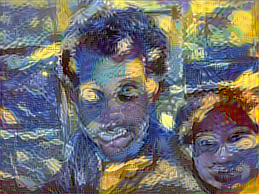

In [83]:
Image.open(path + 'results/res_at_iteration_599.png')

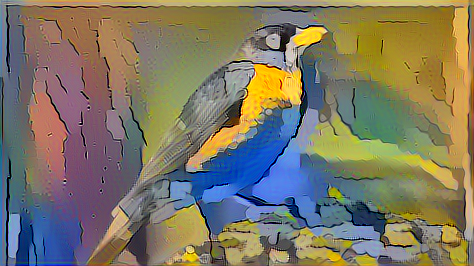

In [932]:
Image.open(path + 'res_at_iteration_9.png')

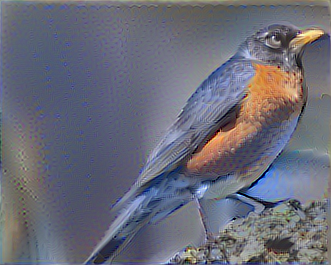

In [914]:
Image.open(path + 'res_at_iteration_9.png')

There are lots of interesting additional things you could try, such as the ideas shown here: https://github.com/titu1994/Neural-Style-Transfer .

## Use content loss to create a super-resolution network

So far we've demonstrated how to achieve succesful results in style transfer. However, there is an obvious drawback to our implementation, namely that we're training an image, not a network, and therefore every new image requires us to retrain. It's not a feasible method for any sort of real-time application. Fortunately we can adress this issue by using a fully convolutional network (FCN), and in particular we'll look at this implementation for Super resolution. We are following the approach in [this paper](https://arxiv.org/abs/1603.08155).

In [7]:
arr_lr = bcolz.open(dpath+'trn_resized_72_r.bc')[:]
arr_hr = bcolz.open(dpath+'trn_resized_288_r.bc')[:]

KeyboardInterrupt: 

In [ ]:
parms = {'verbose': 0, 'callbacks': [TQDMNotebookCallback(leave_inner=True)]}

To start we'll define some of the building blocks of our network. In particular recall the residual block (as used in [Resnet](https://arxiv.org/abs/1512.03385)), which is just a sequence of 2 convolutional layers that is added to the initial block input. We also have a de-convolutional layer (also known as a "transposed convolution" or "fractionally strided convolution"), whose purpose is to learn to "undo" the convolutional function. It does this by padding the smaller image in such a way to apply filters on it to produce a larger image.

In [ ]:
def conv_block(x, filters, size, stride=(2,2), mode='same', act=True):
    x = Convolution2D(filters, size, size, subsample=stride, border_mode=mode)(x)
    x = BatchNormalization(mode=2)(x)
    return Activation('relu')(x) if act else x

In [ ]:
def res_block(ip, nf=64):
    x = conv_block(ip, nf, 3, (1,1))
    x = conv_block(x, nf, 3, (1,1), act=False)
    return merge([x, ip], mode='sum')

In [ ]:
def deconv_block(x, filters, size, shape, stride=(2,2)):
    x = Deconvolution2D(filters, size, size, subsample=stride, 
        border_mode='same', output_shape=(None,)+shape)(x)
    x = BatchNormalization(mode=2)(x)
    return Activation('relu')(x)

In [ ]:
def up_block(x, filters, size):
    x = keras.layers.UpSampling2D()(x)
    x = Convolution2D(filters, size, size, border_mode='same')(x)
    x = BatchNormalization(mode=2)(x)
    return Activation('relu')(x)

This model here is using the previously defined blocks to encode a low resolution image and then upsample it to match the same image in high resolution.

In [737]:
inp=Input(arr_lr.shape[1:])
x=conv_block(inp, 64, 9, (1,1))
for i in range(4): x=res_block(x)
x=up_block(x, 64, 3)
x=up_block(x, 64, 3)
x=Convolution2D(3, 9, 9, activation='tanh', border_mode='same')(x)
outp=Lambda(lambda x: (x+1)*127.5)(x)

The method of training this network is almost exactly the same as training the pixels from our previous implementations. The idea here is we're going to feed two images to Vgg16 and compare their convolutional outputs at some layer. These two images are the target image (which in our case is the same as the original but at higher resolution), and the output of the previous network we just defined, which we hope will learn to output a high resolution image. 

The key then is to train this other network to produce an image that minimizes the loss between the outputs of some convolutional layer in Vgg16 (which the paper refers to as "perceptual loss"). In doing so, we are able to train a network that can upsample an image and recreate the higher resolution details.

In [ ]:
vgg_inp=Input(shp)
vgg= VGG16(include_top=False, input_tensor=Lambda(preproc)(vgg_inp))

Since we only want to learn the "upsampling network", and are just using VGG to calculate the loss function, we set the Vgg layers to not be trainable.

In [ ]:
for l in vgg.layers: l.trainable=False

An important difference in training for super resolution is the loss function. We use what's known as a perceptual loss function (which is simply the content loss for some layer). 

In [ ]:
def get_outp(m, ln): return m.get_layer(f'block{ln}_conv1').output
vgg_content = Model(vgg_inp, [get_outp(vgg, o) for o in [1,2,3]])
vgg1 = vgg_content(vgg_inp)
vgg2 = vgg_content(outp)

In [ ]:
def mean_sqr_b(diff): 
    dims = list(range(1,K.ndim(diff)))
    return K.expand_dims(K.sqrt(K.mean(diff**2, dims)), 0)

In [ ]:
w=[0.1, 0.8, 0.1]
def content_fn(x): 
    res = 0; n=len(w)
    for i in range(n): res += mean_sqr_b(x[i]-x[i+n]) * w[i]
    return res

In [743]:
m_sr = Model([inp, vgg_inp], Lambda(content_fn)(vgg1+vgg2))
targ = np.zeros((arr_hr.shape[0], 1))

Finally we compile this chain of models and we can pass it the original low resolution image as well as the high resolution to train on. We also define a zero vector as a target parameter, which is a necessary parameter when calling fit on a keras model.

In [744]:
m_sr.compile('adam', 'mse')
m_sr.fit([arr_lr, arr_hr], targ, 8, 2, **parms)

We use learning rate annealing to get a better fit.

In [745]:
K.set_value(m_sr.optimizer.lr, 1e-4)
m_sr.fit([arr_lr, arr_hr], targ, 16, 1, **parms)

We are only interested in the trained part of the model, which does the actual upsampling.

In [746]:
top_model = Model(inp, outp)

In [747]:
p = top_model.predict(arr_lr[10:11])

After training for some time, we get some very impressive results! Look at these two images, we can see that the predicted higher resolution image has filled in a lot of detail, including the shadows under the greens and the texture of the food.

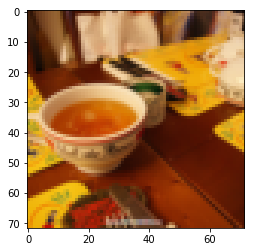

In [267]:
plt.imshow(arr_lr[10].astype('uint8'));

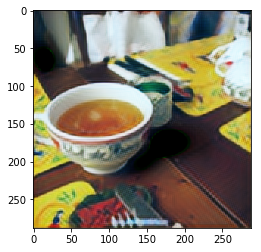

In [748]:
plt.imshow(p[0].astype('uint8'));

In [749]:
top_model.save_weights(dpath+'sr_final.h5')

In [198]:
top_model.load_weights(dpath+'top_final.h5')

The important thing to take away here is that as opposed to our earlier approaches, this type of approach results in a model that can created the desired image and is a scalable implementation.

Note that we haven't used a test set here, so we don't know if the above result is due to over-fitting. As part of your homework, you should create a test set, and try to train a model that gets the best result you can on the test set.

## Fast style transfer

The original paper showing the above approach to super resolution also used this approach to create a much faster style transfer system (for a specific style). Take a look at [the paper](https://arxiv.org/abs/1603.08155) and the very helpful [supplementary material](http://cs.stanford.edu/people/jcjohns/papers/eccv16/JohnsonECCV16Supplementary.pdf). Your mission, should you choose to accept it, it to modify the super resolution example above to do fast style transfer based on this paper. 

### Reflection padding

The supplementary material mentions that that found reflection padding helpful - we have implemented this as a keras layer for you. All the other layers and blocks are already defined above.

(This is also a nice simple example of a custom later that you can refer to when creating your own custom layers in the future.)

In [4]:
class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)
        
    def get_output_shape_for(self, s):
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad,h_pad = self.padding
        return tf.pad(x, [[0,0], [h_pad,h_pad], [w_pad,w_pad], [0,0] ], 'REFLECT')

Testing the reflection padding layer:

In [5]:
inp = Input((288,288,3))
ref_model = Model(inp, ReflectionPadding2D((40,10))(inp))
ref_model.compile('adam', 'mse')

In [13]:
p = ref_model.predict(arr_hr[10:11])

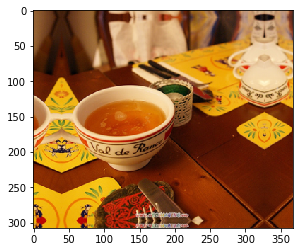

In [14]:
plt.imshow(p[0].astype('uint8'));

### Main algorithm

This approach is exactly the same as super resolution, except now the loss includes the style loss.

In [ ]:
shp = arr_hr.shape[1:]

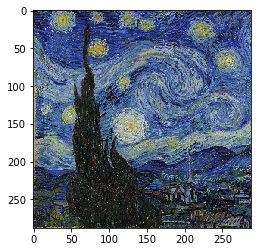

In [38]:
style = Image.open('data/starry_night.jpg')
style = style.resize(np.divide(style.size,3.5).astype('int32'))
style = np.array(style)[:shp[0], :shp[1], :shp[2]]
plt.imshow(style);

In [39]:
def res_crop_block(ip, nf=64):
    x = conv_block(ip, nf, 3, (1,1), 'valid')
    x = conv_block(x,  nf, 3, (1,1), 'valid', False)
    ip = Lambda(lambda x: x[:, 2:-2, 2:-2])(ip)
    return merge([x, ip], mode='sum')

In [40]:
inp=Input(shp)
x=ReflectionPadding2D((40, 40))(inp)
x=conv_block(x, 64, 9, (1,1))
x=conv_block(x, 64, 3)
x=conv_block(x, 64, 3)
for i in range(5): x=res_crop_block(x)
x=up_block(x, 64, 3)
x=up_block(x, 64, 3)
x=Convolution2D(3, 9, 9, activation='tanh', border_mode='same')(x)
outp=Lambda(lambda x: (x+1)*127.5)(x)

In [41]:
vgg_inp=Input(shp)
vgg= VGG16(include_top=False, input_tensor=Lambda(preproc)(vgg_inp))
for l in vgg.layers: l.trainable=False

In [42]:
def get_outp(m, ln): return m.get_layer(f'block{ln}_conv2').output
vgg_content = Model(vgg_inp, [get_outp(vgg, o) for o in [2,3,4,5]])

Here we alter the super resolution approach by adding style outputs

In [43]:
style_targs = [K.variable(o) for o in
               vgg_content.predict(np.expand_dims(style,0))]

In [44]:
[K.eval(K.shape(o)) for o in style_targs]

[array([  1, 144, 144, 128], dtype=int32),
 array([  1,  72,  72, 256], dtype=int32),
 array([  1,  36,  36, 512], dtype=int32),
 array([  1,  18,  18, 512], dtype=int32)]

In [45]:
vgg1 = vgg_content(vgg_inp)
vgg2 = vgg_content(outp)

Our loss now includes the mse for the content loss and the gram matrix for the style

In [46]:
def gram_matrix_b(x):
    x = K.permute_dimensions(x, (0, 3, 1, 2))
    s = K.shape(x)
    feat = K.reshape(x, (s[0], s[1], s[2]*s[3]))
    return K.batch_dot(feat, K.permute_dimensions(feat, (0, 2, 1))
                      ) / K.prod(K.cast(s[1:], K.floatx()))

In [47]:
w=[0.1, 0.2, 0.6, 0.1]
def tot_loss(x):
    loss = 0; n = len(style_targs)
    for i in range(n):
        loss += mean_sqr_b(gram_matrix_b(x[i+n]) - gram_matrix_b(style_targs[i])) / 2.
        loss += mean_sqr_b(x[i]-x[i+n]) * w[i]
    return loss

In [48]:
loss = Lambda(tot_loss)(vgg1+vgg2)
m_style = Model([inp, vgg_inp], loss)
targ = np.zeros((arr_hr.shape[0], 1))

In [ ]:
m_style.compile('adam', 'mae')
m_style.fit([arr_hr, arr_hr], targ, 8, 2, **parms)

In [732]:
K.set_value(m_style.optimizer.lr, 1e-4)
m_style.fit([arr_hr, arr_hr], targ, 16, 1, **parms)

In [49]:
top_model = Model(inp, outp)

Now we can pass any image through this CNN and it will produce it in the style desired!

In [54]:
p = top_model.predict(arr_hr[:20])

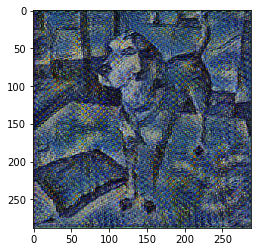

In [69]:
plt.imshow(np.round(p[1]).astype('uint8'));

In [736]:
top_model.save_weights(dpath+'style_final.h5')

In [50]:
top_model.load_weights(dpath+'style_final.h5')

## Next steps

Here's some ideas for things to try:
- https://github.com/junyanz/iGAN
- https://arxiv.org/abs/1605.04603
- https://arxiv.org/abs/1606.05897
- http://cs231n.stanford.edu/reports2016/208_Report.pdf